* load wfstore
* load annots Store
* choose chunker
* choose featurizer
* choose train/test split: mark sessions as train or test


# Using pipeline maker

In [1]:
import os
import soundfile as sf
import pandas as pd
import zipfile
from io import BytesIO
from pathlib import Path

from dol.appendable import add_append_functionality_to_store_cls
from dol import Store
from dol import FilesOfZip, wrap_kvs, filt_iter

from py2store import FilesOfZip
from hear import WavLocalFileStore
from dol import FuncReader



def my_obj_of_data(b):
    return sf.read(BytesIO(b), dtype="float32")[0]

@wrap_kvs(obj_of_data=my_obj_of_data)
@filt_iter(filt=lambda x: not x.startswith("__MACOSX") and x.endswith(".wav"))
class WfZipStore(FilesOfZip):
    """Waveform access. Keys are .wav filenames and values are numpy arrays of int16 waveform."""

    pass


def key_to_ext(k):
    _, ext = os.path.splitext(k)
    if ext.startswith("."):
        ext = ext[1:]
    return ext


def processor_from_ext(ext):
    if ext.startswith("."):
        ext = ext[1:]
    if ext in {"zip"}:
        pass
    elif ext in {"wav"}:
        pass

def is_zip_file(filepath):
    return zipfile.is_zipfile(filepath)

def is_dir(filepath):
    return os.path.isdir(filepath)

def key_maker(name, prefix):
    return f'{prefix}_{name}'

def wf_store_factory(filepath):
    key = key_maker(name = filepath, prefix='wf_store')
    tag = 'wf_store'

    if is_dir(filepath):
        data = WavLocalFileStore(filepath)

         
    elif is_zip_file(filepath):
        data = WfZipStore(filepath)

    return mk_store_item(key, tag, data)

def annot_store_factory(filepath):
    key = key_maker(name = filepath, prefix='annot_store')
    tag = 'annot_store'

    data = pd.read_csv(filepath)

    return mk_store_item(key, tag, data)

def mk_store_item(key, tag, data):
    return dict(key = key, tag = tag, data=data)

def append_to_store(store, item):
    store.append(item)

def dacc_factory():
    pass

factory_store = {'wf_factory': wf_store_factory, 'dacc':None, 'annot_factory':annot_store_factory}

#factory_store = FuncReader([wf_store_factory, dacc_factory])

store_cls = Store
item2kv = lambda item: (item['key'], item['data'])

appendable_store_cls = add_append_functionality_to_store_cls(store_cls, item2kv=item2kv)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# example
rootdir = '/Users/sylvain/Dropbox/Otosense/VacuumEdgeImpulse/'
annot_filepath = '/Users/sylvain/Dropbox/sipyb/Testing/data/annots_vacuum.csv'
#is_dir(rootdir)

In [3]:
# mock functions
def mk_global_store():
    return appendable_store_cls()

def select_wf_factory():
    return {'key':'wf_store_factory', 'data':wf_store_factory}

def select_annot_factory():
    return {'key':'annot_store_factory', 'data':annot_store_factory}

In [4]:
# user story: make a global store and add a wfstore to it

global_store = mk_global_store()
wf_factory = select_wf_factory()
global_store.append(wf_factory)
annot_factory = select_annot_factory()
global_store.append(annot_factory)


In [5]:
global_store

{'wf_store_factory': <function wf_store_factory at 0x7f897cc96b80>, 'annot_store_factory': <function annot_store_factory at 0x7f897cc96c10>}

# Without using pipeline maker

* load wfstore
* load annots Store
* choose chunker
* choose featurizer
* choose model
* train model


In [6]:
d = dict(key = 'example')

In [7]:
d()

TypeError: 'dict' object is not callable

# Scrap

In [ ]:
from meshed import dag
from dol import filt_iter, wrap_kvs, Files, Pipe
import recode

P = Pipe(
    Files,
    filt_iter(filt = lambda x: x.endswith('.wav')),
    wrap_kvs(obj_of_data=recode.decode_wav_bytes)

)

In [ ]:
p = P(rootdir)
list(p)

NameError: name 'rootdir' is not defined

In [ ]:
wf, sr = p['train/noise.DKITCHEN.24.3840000-4000000.wav.23q8e43a.ingestion-6bc8b65f8c-86d4w.wav']

NameError: name 'p' is not defined

In [ ]:
from hum import disp_wf

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
disp_wf(wf)

NameError: name 'wf' is not defined

In [ ]:
list(Files(rootdir))

NameError: name 'rootdir' is not defined

# Make a dag and insert funcs

## Make a mall of factories

In [114]:
# step 1: make a mall of choices
from plunk.sb.front_experiments.streamlitfront_dataprep.data_prep2 import (
    data_from_wav_folder,
    data_from_csv,
    store_to_key_fvs,
    key_fvs_to_tag_fvs,
    mk_Xy
)
from odat.mdat.vacuum import (
    DFLT_ANNOTS_COLS,
    DFLT_CHUNKER,
    DFLT_FEATURIZER,
)

DFLT_CHUNKER_MAKER = lambda:DFLT_CHUNKER
DFLT_FEATURIZER_MAKER = lambda: DFLT_FEATURIZER


m = {'wf_store_maker':[data_from_wav_folder], 'annots_store_maker':[data_from_csv], 
    'chunker':[DFLT_CHUNKER_MAKER],
    'featurizer':[DFLT_FEATURIZER_MAKER]}

#might need to revert a dict if choices are given as a list
choices_list = [data_from_wav_folder, data_from_csv]

choices = {'wf_store_maker':data_from_wav_folder, 'annots_store_maker':data_from_csv, 
    'chunker_maker':DFLT_CHUNKER_MAKER,
    'featurizer_maker': DFLT_FEATURIZER_MAKER,
    'store_to_key_fvs':store_to_key_fvs,
    'key_fvs_to_tag_fvs':key_fvs_to_tag_fvs,
    'mk_Xy':mk_Xy}

In [115]:
# step 2: make a dag connecting these choices

from meshed import DAG, code_to_dag
@code_to_dag
def user_story():
    wf_store = wf_store_maker(wf_filepath) # explicit argument should not be here
    annots_df = annots_store_maker(annot_filepath) #explicit argument should not be here
    chunker = chunker_maker()
    featurizer = featurizer_maker()
    key_fvs = store_to_key_fvs(wf_store, chunker=chunker, featurizer=featurizer)
    tag_fv_iterator = key_fvs_to_tag_fvs(key_fvs, annots_df)
    X,y = mk_Xy(tag_fv_iterator)

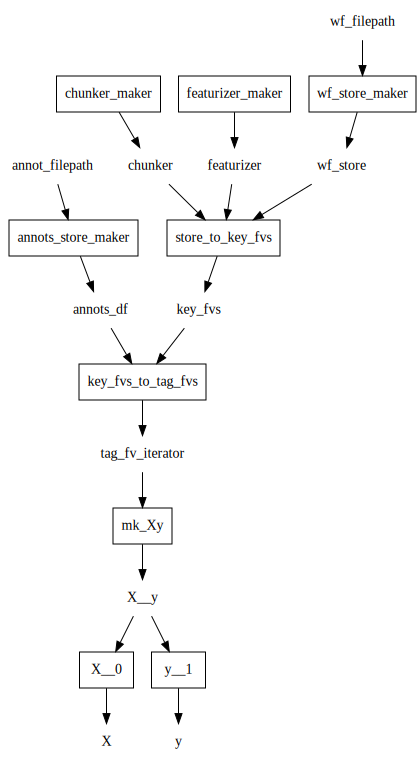

In [116]:
user_story.dot_digraph()

In [117]:
user_story.

SyntaxError: invalid syntax (2651481817.py, line 1)

In [118]:
code_to_dag??

Signature:      
code_to_dag(
    src=None,
    *,
    func_src: Union[Callable[[str], Callable], Mapping[str, Callable]] = <function dlft_factory_to_func at 0x7f895d8f99d0>,
    name: str = None,
) -> meshed.dag.DAG
Call signature:  code_to_dag(*args, **kwargs)
Type:            partial
String form:     functools.partial(<function _double_up_as_factory at 0x7f895d880820>, __decorator_func=<function code_to_dag at 0x7f895d8f9d30>)
File:            ~/Desktop/dev/otosense/meshed/meshed/makers.py
Source:         
@double_up_as_factory
def code_to_dag(
    src=None, *, func_src: FuncSource = dlft_factory_to_func, name: str = None
) -> DAG:
    """Get a ``meshed.DAG`` from src code"""
    func_src = _ensure_func_src(func_src)
    # Get a name for the dag (if src is a str
    if name is None:
        if isinstance(src, str):
            name = _extract_name_from_single_func_def(src, 'dag_made_from_code_parsing')
        else:
            name = name_of_obj(src)
    # Pass on to _code_to_fnode

In [119]:
# Use funcnodes 
# FuncNode(
#              func=my_chunker,
#              name='chunker',
#              bind=dict(sequence='sequence', chk_size='chk_size'),
#              out='chks'
#          ),

In [120]:
from i2 import Sig
metadata_dict={
    'wf_store_maker':{'out':'wf_store', 'sig':Sig('wf_filepath')}
}

In [121]:
# If I remove the arguments wf_filepath and annot_filepath
# I hit the expected problem of same name for the arguments!
user_story =code_to_dag(user_story, func_src=choices) #check code_to_dag to inject also output names
user_story.dot_digraph()

TypeError: module, class, method, function, traceback, frame, or code object was expected, got DAG

In [122]:
# connect dag to inputs
from i2 import Sig
sig = Sig(user_story)
sig

<Sig (wf_filepath, annot_filepath)>

In [123]:
# example
wf_filepath = '/Users/sylvain/Dropbox/Otosense/VacuumEdgeImpulse/'
annots_filepath = '/Users/sylvain/Dropbox/sipyb/Testing/data/annots_vacuum.csv'

In [124]:
user_story(wf_filepath, annots_filepath)

('m', 'k')

In [125]:
# make an app from the dag

# DAG maker

In [126]:
# Assemble a generic dag, from the types appearing in the signatures
# Use types from atypes
chunker: chunker #Generic one
FixedSizeChunker
FixedSizeChunker100
ThresholdChunker
WfStoreMaker
AnnotStoreMaker
featurizer
FeaturizerVolume
FeaturizerTileFFT

-> creates a DAG 
-> DAG is displayed with inputs


featurizer: featurizer

metadata = {'FixedSizeChunker':{'out':'chks'}, 
            'FixedSizeChunker100:{'out':'chks'},
            'ThresholdChunker': {'out':'chks'}
            }

SyntaxError: invalid syntax (3000472892.py, line 13)

In [131]:
metadata = {'FixedSizeChunker':{'func':FixedSizeChunker, 'out':'chks'}, 
            'FixedSizeChunker100':{'out':'chks'},
            'ThresholdChunker': {'out':'chks'},
            'FixedSizeChunkerMaker':{'func':DFLT_CHUNKER_MAKER,'out':'chunker'},
            'FeaturizerMaker':{'func':DFLT_FEATURIZER_MAKER, 'out':'featurizer'},
             'key_fvs_to_tag_fvs':{'func':key_fvs_to_tag_fvs},
            'Featurizer':{'func':DFLT_FEATURIZER, 'out':'fvs'},
            'store_to_key_fvs':{'func':store_to_key_fvs,'out':'key_fvs'},
            'key_fvs_to_tag_fvs':{'func':key_fvs_to_tag_fvs,'out':'tag_fv_iterator'},
            'WfStoreMaker':{'func':data_from_wav_folder, 'out':'wf_store', 'bind':{'filepath':'wf_filepath'}},
            'AnnotsStoreMaker':{'func':data_from_csv, 'out':'annots_df'},
            'mk_Xy':{'func':mk_Xy}
            }

In [135]:
# refactor with functions from meshed.makers

from meshed import FuncNode

FixedSizeChunker = DFLT_CHUNKER
Featurizer = DFLT_FEATURIZER

def funcnode_maker(name):
    kwargs = metadata[name]
    return FuncNode(**kwargs)

def dag_maker(funcnames_list):
    func_nodes = list(map(funcnode_maker, funcnames_list))
    return DAG(func_nodes)

In [133]:
#funcnode_maker('FixedSizeChunker')
funcnames_list = ['FixedSizeChunkerMaker', 'FeaturizerMaker', 'WfStoreMaker', 'AnnotsStoreMaker', 'key_fvs_to_tag_fvs', 'store_to_key_fvs','key_fvs_to_tag_fvs', 'mk_Xy']

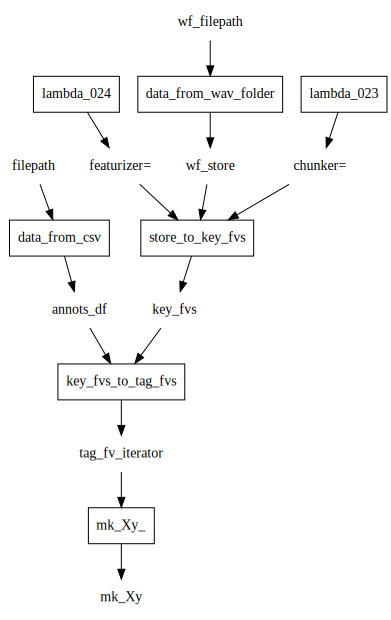

In [134]:
dag = dag_maker(funcnames_list)
dag.dot_digraph()

You read the type of the object, then read from metadata dict the names of the inputs, outputs, then create a funcnode from that info

In [52]:
from atypes.typ import Chunker, Featurizer

def my_chunker(arr):
    pass

chker: Chunker = my_chunker

def chunker_factory()->Chunker:
    pass

def dag_maker(func_list):
    pass

In [7]:
from plunk.sb.front_experiments.streamlitfront_dataprep.data_prep2 import (
    # DFLT_WF_PATH,
    DFLT_ANNOT_PATH,
    data_from_wav_folder,
    data_from_csv,
    store_to_key_fvs,
    key_fvs_to_tag_fvs,
    mk_Xy,
)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [8]:
key_fvs_to_tag_fvs??

Signature: key_fvs_to_tag_fvs(key_fvs, annots_df)
Docstring: <no docstring>
Source:   
def key_fvs_to_tag_fvs(key_fvs, annots_df):
    func = partial(key_to_tag_from_annots, annots_df=annots_df)
    tagger = partial(apply_func_to_index, apply_to_idx=0, func=func)

    yield from map(tagger, key_fvs)
File:      ~/Desktop/dev/otosense/plunk/plunk/sb/front_experiments/streamlitfront_dataprep/data_prep2.py
Type:      function


In [22]:
d= DAG()

In [23]:
d.add_edge()

In [ ]:
from taped import WfChunks
import numpy as np



def gen():
    with WfChunks() as wf_chks:
        for chk in wf_chks:
            yield np.std(chk)

In [6]:
from oscrap.ca.dacc import Dacc

def dacc_to_seg_gen_func(
    wfs_store,
    annotation_gen,
    annot_to_sref_bt_tt,
    seg_and_annot_func,
    annot_filter=lambda x: True,
    flatten=True,
    on_exception=None,
):
    """
    Util to turn the turn the segment_gen method of a dacc into a function usable in a FuncNode
    """
    dacc = Dacc(wfs_store, annotation_gen)
    return dacc.segment_gen(
        annot_filter, annot_to_sref_bt_tt, seg_and_annot_func, flatten, on_exception
    )

SyntaxError: invalid syntax (dacc.py, line 5)

In [1]:
from typing import Callable

f = lambda x, y=0: x + y

class SomeCallableClass(Callable):
    def __init__(self, f):
        self.func = f
    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)

In [2]:
c= SomeCallableClass(f)

In [3]:
c(4)

4

In [4]:
dir(f)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [5]:
import types
d = types.FunctionType(f.__code__, {})


In [6]:
def func_maker(f): # this dynamically creates a function at module load time
    def inner(*args, **kwargs): #this dynamically creates a function on execution of functor
        return f(*args, **kwargs)

    return inner

In [7]:
cc = func_maker(f)

In [13]:
f.__name__

'my_func'

In [5]:
import pickle
f.__name__ = 'my_func'
fff = pickle.loads(pickle.dumps(mf))
assert fff(2, 3) == mf(2, 3) == f(2, 3)

In [3]:
def mf(*args):
    return f(*args)

In [5]:
from i2.deco import FuncFactory
from i2 import Sig
from functools import partial

In [18]:
def foo(x:int, y:int, z:int):
    return x+y

factory = FuncFactory(foo)
Sig(factory)
>>> <Sig (y: int, z: int) -> Callable[..., Any]>

<Sig (y: int, z: int) -> Callable[..., Any]>

In [17]:
Sig(factory(x=2, z=3))

<Sig (*, x: int = 2, y: int, z: int = 3)>

In [15]:
Sig(factory)

<Sig (y: int, z: int) -> Callable[..., Any]>

In [7]:
Factor = lambda func: lambda *args, **kwargs: partial(func, *args, **kwargs)

In [8]:
Sig(Factor(foo))

<Sig (*args, **kwargs)>

In [1]:
from i2 import Pipe

In [2]:
from plunk.sb.front_experiments.streamlitfront_dataprep.data_prep2 import (
    # DFLT_WF_PATH,
    # DFLT_ANNOT_PATH,
    data_from_wav_folder,
    data_from_csv,
    store_to_key_fvs,
    key_fvs_to_tag_fvs,
    mk_Xy,
)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from know.boxes import *
p = Pipe(FuncFactory(data_from_wav_folder))

In [4]:
from i2 import Sig

In [5]:
sig = Sig(p)
sig

<Sig (filepath) -> Callable[..., Any]>

In [6]:
ff = FuncFactory(data_from_wav_folder)

In [7]:
Sig(ff)

<Sig (filepath) -> Callable[..., Any]>

In [8]:
from slang import fixed_step_chunker, mk_chk_fft


In [9]:
Sig(fixed_step_chunker)

<Sig (it, chk_size, chk_step=None, start_at=None, stop_at=None, return_tail=False)>

In [10]:
from i2 import call_forgivingly
chunker = lambda it, chk_size : fixed_step_chunker(it=it, chk_size=chk_size, chk_step=chk_size)
Sig(chunker)

<Sig (it, chk_size)>

In [40]:
def chunker(it, chk_size): 
    return fixed_step_chunker(
    it=it, chk_size=chk_size, chk_step=chk_size
)

In [41]:
p = Pipe(data_from_wav_folder, chunker)

In [42]:
vars(p)

{'objects': {'data_from_wav_folder': <function plunk.sb.front_experiments.streamlitfront_dataprep.data_prep2.data_from_wav_folder(filepath)>,
  'chunker': <function __main__.chunker(it, chk_size)>},
 '__signature__': <Signature (filepath)>,
 'first_func': <function plunk.sb.front_experiments.streamlitfront_dataprep.data_prep2.data_from_wav_folder(filepath)>,
 'other_funcs': [<function __main__.chunker(it, chk_size)>]}

In [43]:
dir(p)

['__abstractmethods__',
 '__call__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setstate__',
 '__signature__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_is_protocol',
 '_process_reserved_names',
 '_reserved_names',
 'auto_namer',
 'first_func',
 'funcs',
 'get',
 'items',
 'keys',
 'objects',
 'other_funcs',
 'values']

In [44]:
p.other_funcs, p.first_func

([<function __main__.chunker(it, chk_size)>],
 <function plunk.sb.front_experiments.streamlitfront_dataprep.data_prep2.data_from_wav_folder(filepath)>)

In [45]:
def first_arg_name(func):
    sig = Sig(func)
    return sig.names[0]

In [46]:
first_arg_name(data_from_wav_folder)

'filepath'

In [57]:
from meshed import FuncNode, DAG

def first_arg_name(func):
    sig = Sig(func)
    return sig.names[0]

def pipe_to_dag(pipe:Pipe):
    first_func=pipe.first_func
    other_funcs = pipe.other_funcs
    output_names = list(map(first_arg_name,other_funcs))
    funcs = [first_func]+other_funcs
    nodes = [FuncNode(func=item, out=name) for item,name in zip(funcs[:-1], output_names)]
    last_node = FuncNode(func=funcs[-1] ,out='result')
    
    return DAG(nodes+[last_node])


In [58]:
dag = pipe_to_dag(p)

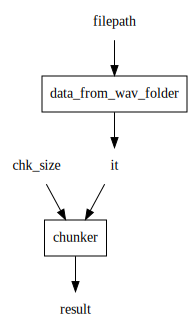

In [59]:
dag.dot_digraph()

In [4]:
>>> import streamlit as st
>>> import numpy as np
>>> path = '/Users/sylvain/Dropbox/Otosense/VacuumEdgeImpulse/train/noise.AirConditioner_9.12.1920000-2080000.wav.23q8e38d.ingestion-6bc8b65f8c-86d4w.wav'
>>> audio_file = open(path, 'rb')
>>> audio_bytes = audio_file.read()
>>>
>>> st.audio(audio_bytes, format='audio/wav')
>>>
>>> sample_rate = 44100  # 44100 samples per second
>>> seconds = 2  # Note duration of 2 seconds
>>> frequency_la = 440  # Our played note will be 440 Hz
>>> # Generate array with seconds*sample_rate steps, ranging between 0 and seconds
>>> t = np.linspace(0, seconds, seconds * sample_rate, False)
>>> # Generate a 440 Hz sine wave
>>> note_la = np.sin(frequency_la * t * 2 * np.pi)
>>>
>>> st.audio(note_la, sample_rate=sample_rate)

2022-11-21 12:55:57.813 
  command:

    streamlit run /Users/sylvain/opt/anaconda3/envs/otopy38/lib/python3.8/site-packages/ipykernel_launcher.py [ARGUMENTS]


TypeError: audio() got an unexpected keyword argument 'sample_rate'

In [5]:
!pip freeze


absl-py==0.13.0
adtk==0.6.2
aiohttp==3.7.4.post0
aioice==0.7.6
aiortc==1.3.2
alabaster==0.7.12
alembic==1.6.5
altair==4.1.0
altgraph==0.17
analytics-python==1.4.0
anvil-parser==0.9.0
anyio==3.0.1
anytree==2.8.0
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
appnope @ file:///Users/runner/miniforge3/conda-bld/appnope_1610094676799/work
argcomplete==1.12.3
argh==0.26.2
argon2-cffi @ file:///Users/runner/miniforge3/conda-bld/argon2-cffi_1625821489228/work
Arpeggio==1.10.2
asgiref==3.4.1
astor==0.8.1
astroid==2.11.6
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1618968359944/work
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1659291887007/work
audioread @ file:///Users/runner/miniforge3/conda-bld/audioread_1649550265523/work
augly==0.1.6
av==9.2.0
ax-platform==0.2.2
axblack==20201112
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_